<a href="https://colab.research.google.com/github/NavyaPatil1011/Deep_learning_and_gen_ai_lab/blob/main/Week8(Mnist).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1, Gen Loss: 0.8143, Disc Loss: 1.1409, Disc Acc: 0.6771
Epoch 2, Gen Loss: 1.1560, Disc Loss: 0.8477, Disc Acc: 0.7891
Epoch 3, Gen Loss: 1.2395, Disc Loss: 0.9038, Disc Acc: 0.7969
Epoch 4, Gen Loss: 1.3453, Disc Loss: 0.7202, Disc Acc: 0.8516
Epoch 5, Gen Loss: 1.7081, Disc Loss: 0.6170, Disc Acc: 0.8464
Epoch 6, Gen Loss: 1.6751, Disc Loss: 0.6879, Disc Acc: 0.8659
Epoch 7, Gen Loss: 1.6596, Disc Loss: 0.6870, Disc Acc: 0.8724
Epoch 8, Gen Loss: 1.7083, Disc Loss: 0.6730, Disc Acc: 0.8216
Epoch 9, Gen Loss: 1.7169, Disc Loss: 0.6409, Disc Acc: 0.8698
Epoch 10, Gen Loss: 1.7141, Disc Loss: 0.7572, Disc Acc: 0.8268


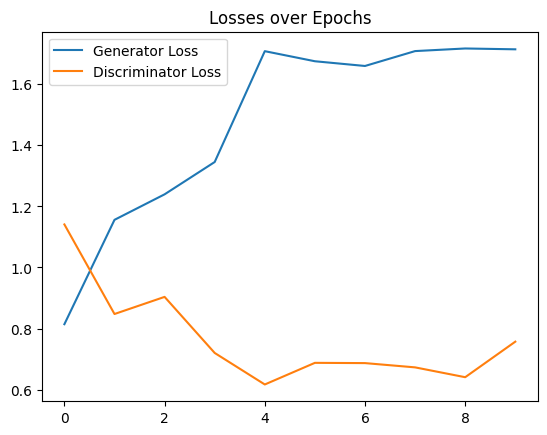

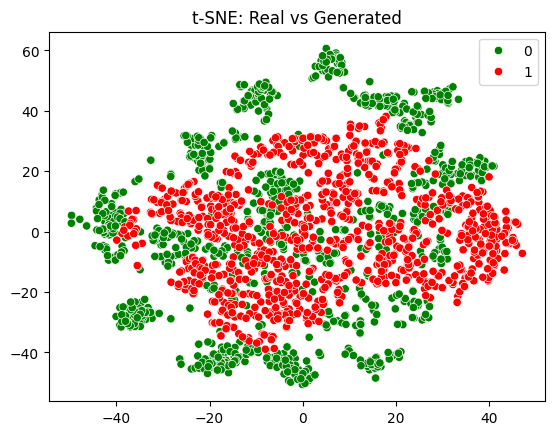

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.manifold import TSNE
import seaborn as sns

# Load dataset: mnist, fashion_mnist or cifar10
dataset_name = 'mnist'  # change to 'fashion_mnist' or 'cifar10'

if dataset_name == 'mnist':
    (x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
    x_train = np.expand_dims(x_train, axis=-1)
    channels = 1
elif dataset_name == 'fashion_mnist':
    (x_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
    x_train = np.expand_dims(x_train, axis=-1)
    channels = 1
else:
    (x_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()
    channels = 3

x_train = tf.image.resize(x_train, [32, 32]).numpy()
x_train = x_train.astype('float32') / 255.0

# Parameters
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 128
NOISE_DIM = 100
EPOCHS = 10
EXAMPLES_TO_GENERATE = 16

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(channels, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

# Discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, channels]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def discriminator_accuracy(real_output, fake_output):
    real_acc = tf.reduce_mean(tf.cast(real_output > 0.5, tf.float32))
    fake_acc = tf.reduce_mean(tf.cast(fake_output < 0.5, tf.float32))
    return (real_acc + fake_acc) / 2.0

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss, discriminator_accuracy(real_output, fake_output)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions * 127.5 + 127.5).numpy().astype(np.uint8)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i].squeeze(), cmap='gray' if channels == 1 else None)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'generated_{dataset_name}_epoch_{epoch:03d}.png')
    plt.close()

gen_losses, disc_losses, acc_list = [], [], []
seed = tf.random.normal([EXAMPLES_TO_GENERATE, NOISE_DIM])

def train(dataset, epochs):
    for epoch in range(1, epochs + 1):
        for image_batch in dataset:
            g_loss, d_loss, acc = train_step(image_batch)
        gen_losses.append(g_loss.numpy())
        disc_losses.append(d_loss.numpy())
        acc_list.append(acc.numpy())
        print(f'Epoch {epoch}, Gen Loss: {g_loss.numpy():.4f}, Disc Loss: {d_loss.numpy():.4f}, Disc Acc: {acc.numpy():.4f}')
        generate_and_save_images(generator, epoch, seed)

    # Plot losses
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.title("Losses over Epochs")
    plt.legend()
    plt.show()

    # t-SNE visualization
    noise = tf.random.normal([1000, NOISE_DIM])
    generated = generator(noise, training=False).numpy()
    real = x_train[:1000]
    combined = np.concatenate([real.reshape(1000, -1), generated.reshape(1000, -1)])
    labels = np.array([0]*1000 + [1]*1000)
    embeddings = TSNE(n_components=2).fit_transform(combined)
    sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1], hue=labels, palette=['green', 'red'])
    plt.title('t-SNE: Real vs Generated')
    plt.show()

train(train_dataset, EPOCHS)
